In [9]:
import torch
import torchvision
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.misc
import scipy.stats as stats
import scipy.io 
from scipy.special import expit
from PIL import Image
import os

In [6]:
# Load MNIST
raw_data_dir = "../data/mnist/"
processed_data_dir = "../data/mnist/processed/"
trans = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))])
                           
mnist_dataset = datasets.MNIST(raw_data_dir, download=True, transform=trans)

Colorize the images by embedding a background, also add some pepper as noise.

In [9]:
def colorize_image(img, pepper_amount=0.05):
    color_img = Image.open(raw_data_dir + 'sample.jpg')
    color_img = color_img.resize((128, 128)) 
    img = img.reshape(28, 28, 1) / 255.0

    # resize the mnist images to 64 x 64
    sample_resized = scipy.ndimage.zoom(img, (2.3, 2.3, 1), order=1)
    rgb_sample_digit = np.concatenate([sample_resized, sample_resized, sample_resized], axis=2)
    sample_binary = (rgb_sample_digit > 0.5)

    x_c = np.random.randint(0, color_img.size[0] - 64)
    y_c = np.random.randint(0, color_img.size[1] - 64)
    image = color_img.crop((x_c, y_c, x_c + 64, y_c + 64))
    image = np.asarray(image) / 255.0

    colorized_image = np.zeros_like(rgb_sample_digit)
    for ch in range(3):
        img_chwise = image[:, :, ch]
        ch_binary = sample_binary[:, :, ch]
        # color jitter
        img_chwise = (img_chwise + np.random.uniform(0, 0.2)) / 2.0
        # add pepper
        num_pepper_pixels = np.ceil(pepper_amount * img_chwise.size)
        r_size, c_size = img_chwise.shape

        row_coords = np.random.randint(0, r_size-1, int(num_pepper_pixels))
        col_coords = np.random.randint(0, c_size-1, int(num_pepper_pixels))
        # only apply the pepper to pixels that are not 
        # part of the original digit activation
        for coord_idx in zip(row_coords, col_coords):
            if not ch_binary[coord_idx]:
                img_chwise[coord_idx] = 0

        # reduce the pixel value for the background image
        # so we can easily distingush between the digit pixels
        # and the background pixels. 
        # In this setting, the larger pixel values will always be
        # be associated with the useful "codes". 
        img_chwise /= 1.5
        img_chwise[ch_binary] = 1 - img_chwise[ch_binary]
        colorized_image[:, :, ch] = img_chwise

    return (colorized_image * 255).astype(np.uint8), (sample_resized.squeeze() * 255).astype(np.uint8)

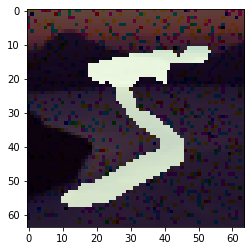

In [22]:
colorized_img, sample_img = colorize_image(mnist_dataset.data[0], pepper_amount = 0.1)

im1 = plt.imshow(colorized_img)
plt.show()

Next, groups every 4 pixels into a chunk, which represents a single visit. Then, randomly drops some chunks to mimic the missing nature of EHR.

In [4]:
def drop_row_chunks_from_image(input_image, chunk_size, drop_ratio):
    """
    Drops random chunks of pixels from the input_image. To do this, we create a mask
    having ones at locations where we'd like to retain the chunks and zeroes where
    we'd like them dropped. 
    The mask itself is created using a kronecker product, which is used to create
    block matrices.
    """
    dropped_image = np.zeros_like(input_image)
    # 1. mask is a kronecker product of two matrices
    # 2. the bigger matrix has ones where we'd like to retain
    # the chunks and zeroes where we'd like them dropped
    # 3. The smaller matrix is of size == chunk_size (in our case 4 pixels in a row)
    kr_mask_bigger = np.ones((
        input_image.shape[0], 
        input_image.shape[1]//chunk_size
    ))
    kr_mask_smaller = np.ones((chunk_size,))
    chunks_to_drop = int(kr_mask_bigger.size * drop_ratio)
    drop_indices = np.random.choice(
        a=kr_mask_bigger.size, 
        size=chunks_to_drop, 
        replace=False
    )
    kr_mask_bigger.flat[drop_indices] = 0
    img_mask = np.kron(kr_mask_bigger, kr_mask_smaller)
    for ch in range(3):
        img_ch = input_image[:, :, ch]
        img_ch_dropped = img_ch * img_mask
        dropped_image[:, :, ch] = img_ch_dropped
    
    return dropped_image

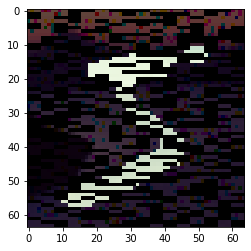

In [25]:
dropped_img = drop_row_chunks_from_image(colorized_img, chunk_size = 4, drop_ratio = 0.5)

im1 = plt.imshow(dropped_img)
plt.show()

Finally, combine the above functions into one single func.

In [29]:
def add_noise_and_colorize(images, labels):
    
    # Upper top of the image
    upper_box_64 = (0, 0, 64, 48)

    # Extract digits eight and nine
    eight_idx = torch.tensor(labels)==8
    eight_imgs = images[eight_idx]
    eight_labels = labels[eight_idx]

    nine_idx = torch.tensor(labels)==9
    nine_imgs = images[nine_idx]
    nine_labels = labels[nine_idx]

    imgs = np.concatenate((eight_imgs, nine_imgs))
    labels = np.concatenate((eight_labels, nine_labels))
    X_colored = []
    
    # Process X
    print("processing x")
    for i in range(imgs.shape[0]):
        p_img = imgs[i, :, :]
        
        pepper_noise_amount = np.random.uniform(0.05, 0.1)
        colorized_img, _ = colorize_image(p_img, pepper_noise_amount)
        dropped_image = drop_row_chunks_from_image(colorized_img, 4, 0.2)
        p_img_color = Image.fromarray(dropped_image)
        upper_r = np.array(p_img_color.crop(box=upper_box_64))

        X_colored.append(np.expand_dims(upper_r, axis=0))

    out_dir = processed_data_dir + 'colorized-noisy-mnist.npz'
    X_colored = np.array(X_colored)
    np.savez(
        out_dir, 
        x = X_colored,
        labels = labels
    )
    print("done!")

In [30]:
add_noise_and_colorize(mnist_dataset.data, mnist_dataset.targets)

<ipython-input-29-d51c482ada5b>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eight_idx = torch.tensor(labels)==8
<ipython-input-29-d51c482ada5b>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nine_idx = torch.tensor(labels)==9


processing x
done!


Assigning treatment and potential outcomes. 

In [7]:
import random
from scipy.special import expit, logit
from scipy.stats import bernoulli
def prepare_treatment_and_confounder():

    """
    Simulate treatment and outcome for MNIST dataset

    Parameters:
        outcome_type (str): 'binary' or 'continuous'
        beta0 (float): Treatment strength, indicates the influence of the treatment on outcomes
        beta1 (float): Confounding strength, indicates the influence of confounders on outcomes
        gamma (float): mean value to sample noise from (eps ~ N(0, gamma))
        
    Returns:
        nil
    """
    data_dir = processed_data_dir + 'colorized-noisy-mnist.npz'
    
    # Prepare the colorized and noisy dataset if file not found from disk
    if os.path.isfile(data_dir) == False:
        add_noise_and_colorize(mnist_dataset.data, mnist_dataset.targets)

    data = np.load(data_dir)
    images = data["x"]
    labels = data["labels"]
    seq1, seq2, seq3 = images[:, :, :, :, 0], images[:, :, :, :, 1], images[:, :, :, :, 2]
    no = images.shape[0] # num samples
    dim = images.shape[2] * images.shape[3] # weight vector dim (48x64)
     
    # Let the digit value be a confounder
    # That is, '8' patients will more likely receive treatments compared to the '9' patients
    t = np.zeros([no,])
    for i in range(len(labels)):
        if labels[i] == 8:
            t[i] = 1 if random.random() < 0.5 else 0
        else:
            t[i] = 1 if random.random() < 0.1 else 0
    
    # True propensity score: the proportion of t=1 in each strata (8 or 9)
    e_idx = np.where(labels == 8)
    n_idx = np.where(labels ==  9)
    
    pi = np.zeros([no,])
    
    # proportion = |t[idx] = 1| / |t[idx]|
    pi[e_idx] = len(np.where(t[e_idx] == 1)[0]) / len(t[e_idx])
    pi[n_idx] = len(np.where(t[n_idx] == 1)[0]) / len(t[n_idx])
          
    xs_1, xs_2, xs_3 = [], [], []
    for idx in range(no):
        # prepare x_oracles
        x_sample_r = images[idx][:, :, :, 0].reshape((-1, 4))
        x_sample_r = np.concatenate([x_sample_r, 256 * np.ones((x_sample_r.shape[0], 1))], axis=1)
        x_sample_r = np.concatenate([x_sample_r.flatten(), np.array([257])], axis=0)
        x_sample_r = x_sample_r.astype(np.int32)
        xs_1.append(x_sample_r)

        x_sample_r = images[idx][:, :, :, 1].reshape((-1, 4))
        x_sample_r = np.concatenate([x_sample_r, 256 * np.ones((x_sample_r.shape[0], 1))], axis=1)
        x_sample_r = np.concatenate([x_sample_r.flatten(), np.array([257])], axis=0)
        x_sample_r = x_sample_r.astype(np.int32)
        xs_2.append(x_sample_r)

        x_sample_r = images[idx][:, :, :, 2].reshape((-1, 4))
        x_sample_r = np.concatenate([x_sample_r, 256 * np.ones((x_sample_r.shape[0], 1))], axis=1)
        x_sample_r = np.concatenate([x_sample_r.flatten(), np.array([257])], axis=0)
        x_sample_r = x_sample_r.astype(np.int32)
        xs_3.append(x_sample_r)

    # all_Xs: context
    # all_ts: treatments
    # all_y0_trues, all_y1_trues: potential outcome given treatment 't'
    # all_labels: factual outcome
    print("saving...")
    out_dir = processed_data_dir + 'mnist-cfr.npz'
    np.savez(
        out_dir, 
        xs_1 = xs_1, xs_2 = xs_2, xs_3 = xs_3, t = t, confounder = pi
    )
    print("done!")
    

In [10]:
prepare_treatment_and_confounder()

saving...
done!
